In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('drive/My Drive')

In [0]:
data[1].shape

(2,)

In [0]:
import numpy as np
data=np.load('images.npy',allow_pickle=True)

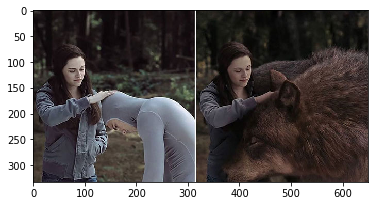

In [0]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(data[0][0])

In [0]:
data[1][1]

[{'imageHeight': 697,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527},
   {'x': 0.7692307692307693, 'y': 0.36182902584493043}]}]

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [0]:
X_train.shape

(409, 224, 224, 3)

In [0]:
masks.shape

(409, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.83529413 -0.72549021 -0.65490198]
  [-0.82745099 -0.70980394 -0.63921571]
  [-0.81176472 -0.68627453 -0.62352943]
  ...
  [-0.87450981 -0.81960785 -0.77254903]
  [-0.87450981 -0.81960785 -0.75686276]
  [-0.86666667 -0.79607844 -0.73333335]]

 [[-0.8509804  -0.7019608  -0.65490198]
  [-0.8509804  -0.7019608  -0.65490198]
  [-0.83529413 -0.68627453 -0.63921571]
  ...
  [-0.86666667 -0.81176472 -0.7647059 ]
  [-0.84313726 -0.78823531 -0.72549021]
  [-0.83529413 -0.7647059  -0.70980394]]

 [[-0.84313726 -0.67843139 -0.63921571]
  [-0.83529413 -0.67058825 -0.63137257]
  [-0.84313726 -0.67843139 -0.63921571]
  ...
  [-0.85882354 -0.80392158 -0.75686276]
  [-0.81960785 -0.7647059  -0.70980394]
  [-0.81176472 -0.74117649 -0.68627453]]

 ...

 [[-0.71764708 -0.59215689 -0.52941179]
  [-0.7019608  -0.57647061 -0.51372552]
  [-0.69411767 -0.59215689 -0.52156866]
  ...
  [-0.90588236 -0.81960785 -0.77254903]
  [-0.9137255  -0.82745099 -0.78039217]
  [-0.90588236 -0.81960785 -0.77254903]]

 [

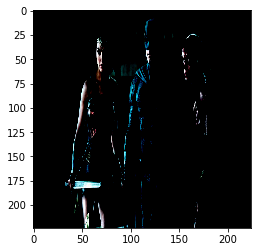

In [0]:
from matplotlib import pyplot
n = 15
print(X_train[n])
pyplot.imshow(X_train[n])

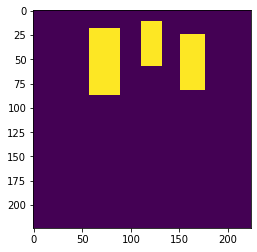

In [0]:
pyplot.imshow(masks[n])

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape,MaxPooling2D
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(224,224,3),include_top=False)
    for layer in model.layers:
        layer.trainable = trainable

    outputs=model.layers[-1].output
    block00 = model.get_layer("conv_pw_1_relu").output
    block0 = model.get_layer("conv_pw_3_relu").output
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x=  Concatenate()([UpSampling2D()(x), block0])
    x=  Concatenate()([UpSampling2D()(x), block00])
    x=  UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((224, 224))(x)


    return Model(inputs=model.input, outputs=x) 

### Call the create_model function

In [0]:
model = create_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________

In [0]:
def dice_coefficient(y_true, y_pred):
    return (2 * y_true * y_pred) / (y_true + y_pred + 0.0000000000000000001)    

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [0]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,TensorBoard
!rm -rf ./logs/ 
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [0]:
model.fit(X_train,masks,batch_size=1,epochs=50,callbacks=[tensorboard_callback,checkpoint, reduce_lr, stop],verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 409 samples
Epoch 1/50
408/409 [============================>.] - ETA: 0s - loss: 14.5617 - dice_coefficient: 0.0755
Epoch 00001: loss improved from inf to 14.56449, saving model to model-14.56.h5
409/409 [==============================] - 32s 79ms/sample - loss: 14.5645 - dice_coefficient: 0.0754
Epoch 2/50
408/409 [============================>.] - ETA: 0s - loss: 14.3417 - dice_coefficient: 0.0962
Epoch 00002: loss improved from 14.56449 to 14.33513, saving model to model-14.34.h5
409/409 [==============================] - 24s 58ms/sample - loss: 14.3351 - dice_coefficient: 0.0965
Epoch 3/50
408/409 [============================>.] - ETA: 0s - loss: 14.2794 - dice_coefficient: 0.1025
Epoch 00003: loss improved from 14.33513 to 14.28258, saving model to model-14.28.h5
409/409 [==============================] - 24s 58ms/sample - loss: 14.2826 - dice_coefficient: 0.1024
Epoch 4/50
408

In [0]:
%load_ext tensorboard
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [0]:
n = 10
sample_image = X_train[n]

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0]

### Impose the mask on the image (5 marks)

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape,MaxPooling2D
from tensorflow.keras.models import Model


def create_modelOD(trainable=True):
    model = MobileNet(input_shape=(224,224,3),include_top=False)
    for layer in model.layers:
        layer.trainable = trainable

    outputs=model.layers[-1].output
    x = Conv2D(4, kernel_size=4, activation="sigmoid")(outputs)
    x = Reshape((4, ))(x)

    # Add all the UNET layers here
    #### Add your code here ####

    return Model(inputs=model.input, outputs=x) #### Add your code here ####

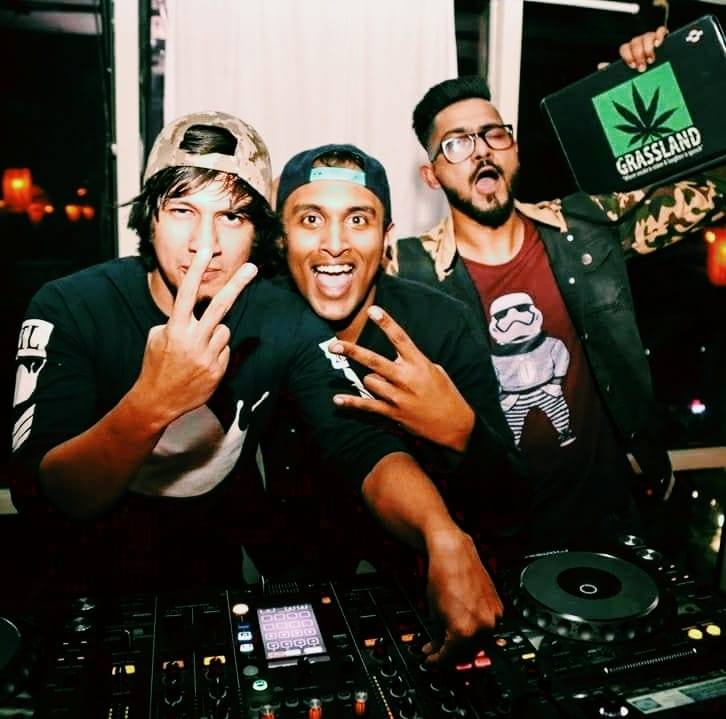

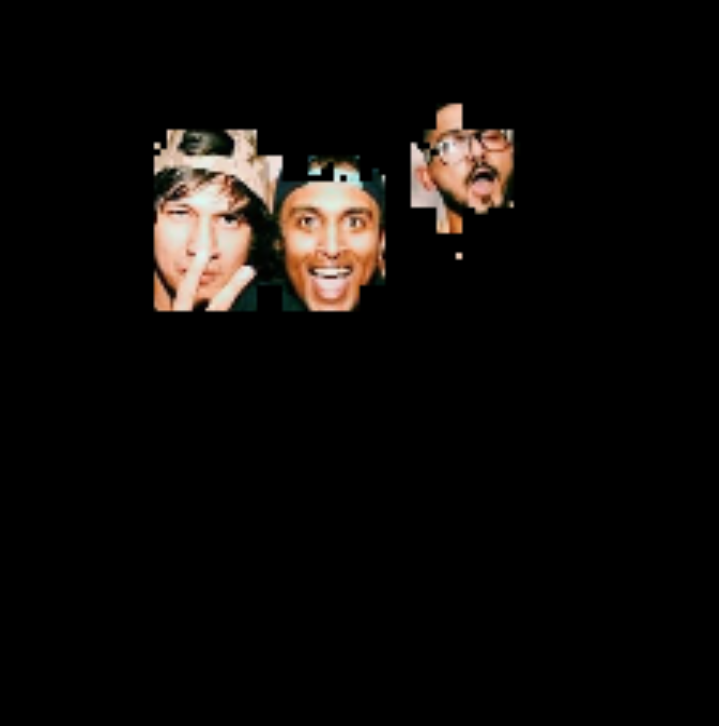

In [0]:
filename='friend.jpg'
from google.colab.patches import cv2_imshow
unscaled = cv2.imread(filename)
cv2_imshow(unscaled)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.1), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2
out_image = cv2.resize(out_image, (unscaled.shape[0], unscaled.shape[1]))

cv2_imshow(out_image)